### Basic Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#reading data
data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
data

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938


### Notes about the data to help me better understand it:
#### The goal is to predict the airway pressure of a patient based on two control
#### inputs:  R -> airway resistance  , C-> lung compliance  , breath_id ->unique for every patient 
#### u_in: control input. Ranges from 0 to 100.
#### u_out: control input Either 0 or 1.

### Data Preprocessing

In [4]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

In [5]:
# start data cleaning process
# check if the data type of each column is correct (a number is a number and not a string) 
# every coloumn has correct data type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [6]:
# check for nulls
data.isnull().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

In [7]:
#check for na
data.isna().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

In [8]:
# check for duplicated rows 
# since all values == False therefore no duplicates
data.duplicated().all() == False

True

In [9]:
#check data for correct values
# since pressure in the data is measured in cmH2O therefore it is not expected to be zero so we will have to remove these rows
data.drop(data[data['pressure']<0].index,inplace=True)
data.shape

(6032287, 8)

In [10]:
#u_in: control input. Ranges from 0 to 100.
# u_out: control input Either 0 or 1.
data.drop(data[data['u_in']<0].index,inplace=True)
data.drop(data[data['u_in']>100].index,inplace=True)
data.drop(data[(data['u_out']>1)].index,inplace=True)
data.drop(data[(data['u_out']>0) & (data['u_out']<1)].index,inplace=True)
data.drop(data[data['u_out']<0].index,inplace=True)
# since R and C are (air volume per time) therefore they should be bigger than zero
data.drop(data[data['C']<0].index,inplace=True)
data.drop(data[data['R']<0].index,inplace=True)
data.shape

(6032287, 8)

In [11]:
def box_plot(data,col_name):
    sns.boxplot(data[col_name])
    plt.title(col_name)
    plt.show()

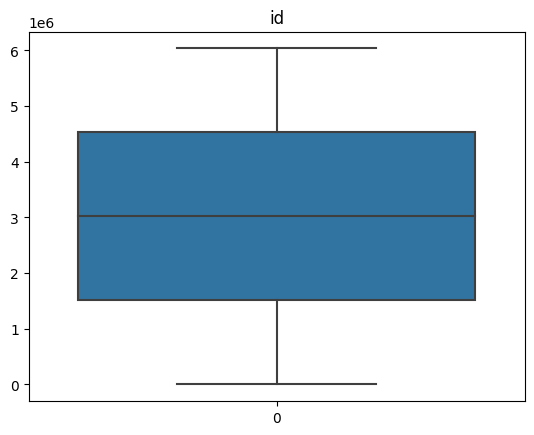

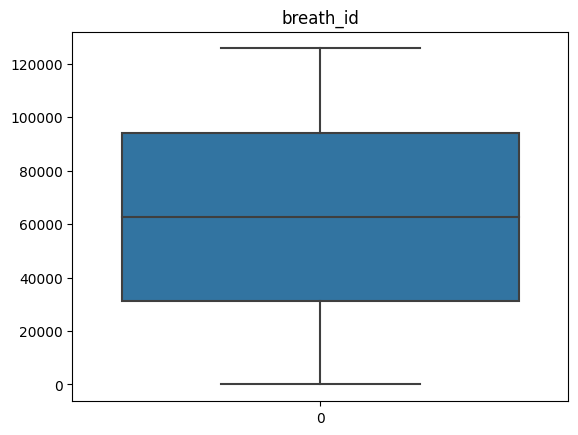

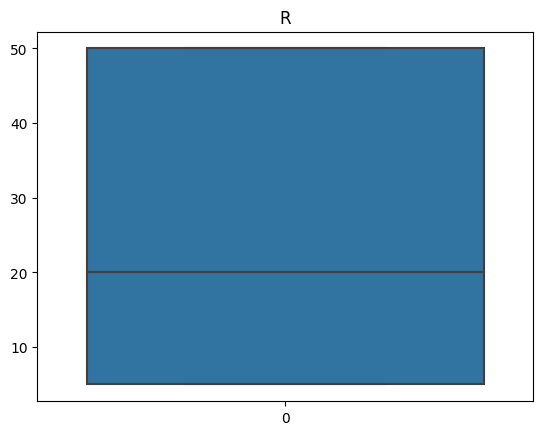

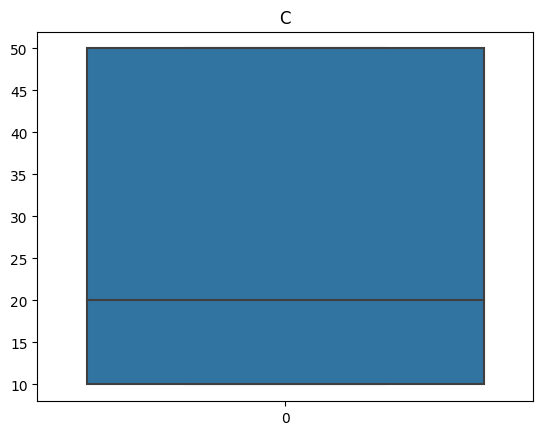

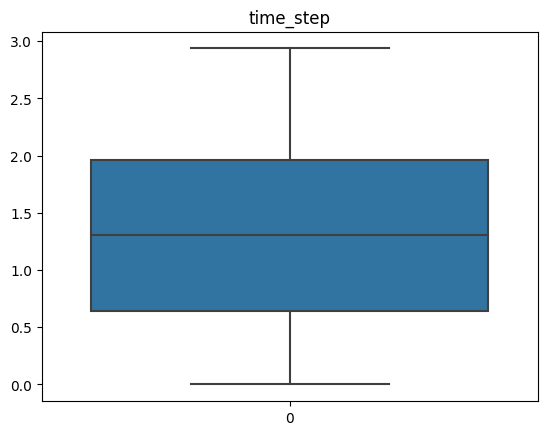

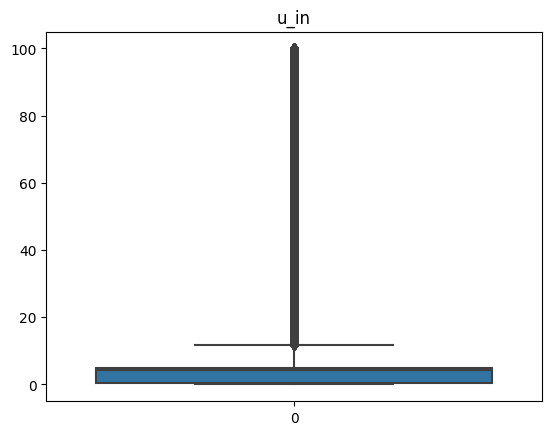

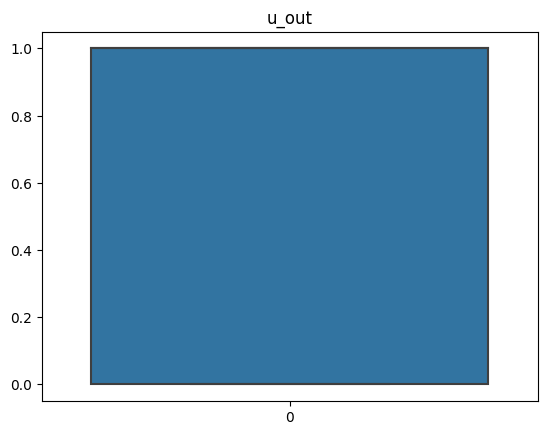

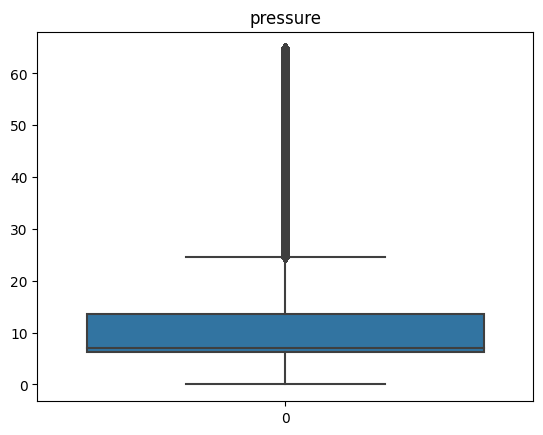

In [253]:
#check for outliers
#desplay the box plot for columns in the data
for i in data.columns:
    box_plot(data,i)

In [11]:
# remove outliers using IQR method 
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

In [12]:
# remove outliers from the 2 columns having the greatest number of outliers in according to graphs
data = remove_outliers_iqr(data,'u_in')
data = remove_outliers_iqr(data,'pressure')
data.shape

(4417489, 8)

In [13]:
#breath_id in this data referes to a certain patien for the same number therfore we can add its cumulative sum as a column
#which will add a lyer of complexity to the data so that the models can train better
#cumilation will be done on u_in column
# reference https://www.kaggle.com/code/ranjeetshrivastav/ventilator-pressure-prediction-xgboost
data["u_in_cumilate"] = (data['u_in']).groupby(data['breath_id']).cumsum()
test["u_in_cumilate"] = (test['u_in']).groupby(test['breath_id']).cumsum()

In [14]:
data['u_in_lag'] = data['u_in'].shift(2)
data = data.fillna(0)

test['u_in_lag'] = test['u_in'].shift(2)
test = test.fillna(0)

In [15]:
# make sure again that no nan is found in the data 
data.fillna(0,inplace=True)
test.fillna(0,inplace=True)

In [16]:
data.head(1)

,id,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_cumilate,u_in_lag
0,1,1,20,50,0.0,0.083334,0,5.837492,0.083334,0.0


In [17]:
test.head(1)

,id,breath_id,R,C,time_step,u_in,u_out,u_in_cumilate,u_in_lag
0,1,0,5,20,0.0,0.0,0,0.0,0.0


In [18]:
#drop useless trainning columns 
data.drop(['id','breath_id'],axis=1,inplace=True)
test.drop(['id','breath_id'],axis=1,inplace=True)

In [19]:
data.head(1)

,R,C,time_step,u_in,u_out,pressure,u_in_cumilate,u_in_lag
0,20,50,0.0,0.083334,0,5.837492,0.083334,0.0


In [20]:
#split data to X,Y
X = data.loc[:,:'u_in_lag']
X.drop('pressure',axis=1,inplace=True)
y = data.loc[:,'pressure']

In [21]:
X.head(1)

,R,C,time_step,u_in,u_out,u_in_cumilate,u_in_lag
0,20,50,0.0,0.083334,0,0.083334,0.0


In [22]:
y.head(1)

0    5.837492
Name: pressure, dtype: float64

In [22]:
#normalize
env = EllipticEnvelope(contamination=0.05)

In [ ]:
env.fit(X)

In [ ]:
outliers = env.predict(X) == -1

# Remove the outliers
X = X[~outliers]

In [24]:
#normalize Data 
norm=Normalizer(norm='l2')
ss = StandardScaler()

In [25]:
# normalize training data
norm_data = X.copy()
norm_data = pd.DataFrame(ss.fit_transform(norm_data), columns=X.columns[0:])
X = norm_data

In [26]:
#normalize test data
norm_data = test.copy()
norm_data = pd.DataFrame(ss.fit_transform(norm_data), columns=test.columns[0:])
test = norm_data

In [27]:
#add another layer of polynomial complexity
poly = PolynomialFeatures(2)

In [28]:
poly = X.copy()
poly = pd.DataFrame(norm.fit_transform(poly), columns=X.columns[0:])
X = poly

In [29]:
poly = test.copy()
poly = pd.DataFrame(norm.fit_transform(poly), columns=test.columns[0:])
test = poly

In [30]:
X.head()

,R,C,time_step,u_in,u_out,u_in_cumilate,u_in_lag
0,-0.095103,0.346567,-0.560611,-0.308923,-0.523264,-0.294100,-0.317535
1,-0.139995,0.510161,-0.255781,-0.467424,0.174114,-0.432928,-0.467424
2,-0.141450,0.515462,-0.240490,-0.472281,0.175923,-0.437427,-0.459472
3,-0.141198,0.514544,-0.222029,-0.471440,0.175610,-0.436647,-0.471440
4,-0.141739,0.516516,-0.204928,-0.473247,0.176283,-0.438321,-0.473247


### Try ML Models

In [31]:
from sklearn.model_selection import train_test_split
from sklearnex import patch_sklearn
patch_sklearn()

#Models
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor

# model evaluation metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [34]:
def Evaluate(Name,Y_test,predictions):
    print(f"{Name} MSE is {mean_squared_error(Y_test,predictions)}")
    print(f"R2 Score:\n {r2_score(Y_test,predictions)} \n")

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((3533991, 7), (3533991,), (883498, 7), (883498,))

In [47]:
#try XGboost
random_grid = {
    'n_estimators' : [5,10,15],
    'max_depth' : [3,5,7],
    'min_child_weight' : [0.05, 0.10, 0.15]
}

In [48]:
xgbr = xg.XGBRegressor(seed = 42, n_jobs=-1)

In [49]:
random_grid_search = RandomizedSearchCV(estimator = xgbr, param_distributions = random_grid, n_iter = 5, cv = 3, verbose = 2, random_state = 42, n_jobs = -1, scoring = 'neg_mean_squared_error').fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [50]:
print('Best Score: ', random_grid_search.best_score_) 
print('Best Params: ', random_grid_search.best_params_)

Best Score:  -1.4037851432564967
Best Params:  {'n_estimators': 10, 'min_child_weight': 0.1, 'max_depth': 5}


In [51]:
pred = random_grid_search.predict(X_test)

In [52]:
Evaluate("XGBR",y_test,pred)

XGBR MSE is 1.4132345296912718
R2 Score:
 0.7003381098922066 



In [53]:
#try KNN
knn = KNeighborsRegressor().fit(X_train,y_train)

In [54]:
knn_pred = knn.predict(X_test)

In [55]:
Evaluate("knn",y_test,knn_pred)

knn MSE is 0.8547859199096308
R2 Score:
 0.8187514110247467 



In [37]:
#try RandomForest
forest = RandomForestRegressor().fit(X_train,y_train)

In [38]:
forest_predict = forest.predict(X_test)

In [39]:
Evaluate("Forest",y_test,forest_predict)

Forest MSE is 0.5911484891492916
R2 Score:
 0.8746530247661433 



### Since RandomForestwas the best it prediction will be done on it

In [36]:
sub_sample = pd.read_csv('data/sample_submission.csv')

In [37]:
sub_sample.head()

,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [40]:
pressure = forest.predict(test)

In [41]:
sub_sample['pressure'] = pressure

In [42]:
sub_sample

,id,pressure
0,1,6.383779
1,2,6.072020
2,3,7.004591
3,4,7.372363
4,5,9.273978
...,...,...
4023995,4023996,6.116307
4023996,4023997,6.243340
4023997,4023998,6.227242
4023998,4023999,6.150711


In [43]:
sub_sample.to_csv('pressure_pred.csv',index=False)

In [45]:
pred = pd.read_csv('pressure_pred.csv')

In [46]:
pred

,id,pressure
0,1,6.383779
1,2,6.072020
2,3,7.004591
3,4,7.372363
4,5,9.273978
...,...,...
4023995,4023996,6.116307
4023996,4023997,6.243340
4023997,4023998,6.227242
4023998,4023999,6.150711
